In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('/Users/kaiser/Downloads/output.csv')

In [3]:
df.head()

,adult,genre_ids,id,original_language,original_title,overview,popularity,release_date,title,video,vote_average,vote_count
0,False,"878,28,12",823464,en,Godzilla x Kong: The New Empire,"Following their explosive showdown, Godzilla a...",6160.662,2024-03-27,Godzilla x Kong: The New Empire,False,7.300,1942
1,False,"878,12,28",653346,en,Kingdom of the Planet of the Apes,Several generations in the future following Ca...,1739.020,2024-05-08,Kingdom of the Planet of the Apes,False,7.173,495
2,False,"18,10770",1219685,fr,Un père idéal,NaN,1220.110,2024-04-21,Un père idéal,False,6.300,24
3,False,"878,27,28",940721,ja,ゴジラ-1.0,Postwar Japan is at its lowest point when a ne...,1234.671,2023-11-03,Godzilla Minus One,False,7.666,1107
4,False,"878,12",693134,en,Dune: Part Two,Follow the mythic journey of Paul Atreides as ...,986.674,2024-02-27,Dune: Part Two,False,8.184,4011


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   adult              10000 non-null  bool   
 1   genre_ids          9977 non-null   object 
 2   id                 10000 non-null  int64  
 3   original_language  10000 non-null  object 
 4   original_title     10000 non-null  object 
 5   overview           9961 non-null   object 
 6   popularity         10000 non-null  float64
 7   release_date       9989 non-null   object 
 8   title              10000 non-null  object 
 9   video              10000 non-null  bool   
 10  vote_average       10000 non-null  float64
 11  vote_count         10000 non-null  int64  
dtypes: bool(2), float64(2), int64(2), object(6)
memory usage: 800.9+ KB


In [4]:
C = df['vote_average'].mean()
C

6.3778226

In [5]:
m = df['vote_count'].quantile(0.9)
m

4339.300000000005

In [6]:
q_mv = df.copy().loc[df['vote_count'] >= m]
q_mv.shape

(1000, 12)

In [7]:
def weighted_rating(x, m = m, C= C):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [8]:
q_mv['score'] = q_mv.apply(weighted_rating, axis=1)

In [9]:
q_mv = q_mv.sort_values('score', ascending= False)
q_mv[['original_title', 'vote_count', 'vote_average', 'score']].head(10)

,original_title,vote_count,vote_average,score
507,The Shawshank Redemption,26189,8.705,8.374214
84,Interstellar,34371,8.434,8.203509
89,Pulp Fiction,27098,8.489,8.197594
76,Pulp Fiction,27098,8.489,8.197594
93,Inception,35741,8.367,8.151641
72,Inception,35741,8.367,8.151641
523,The Lord of the Rings: The Return of the King,23415,8.480,8.151331
487,The Lord of the Rings: The Fellowship of the Ring,24352,8.412,8.104349
952,기생충,17550,8.509,8.086519
859,Schindler's List,15398,8.568,8.086483


Text(0.5, 1.0, 'Popular Movies')

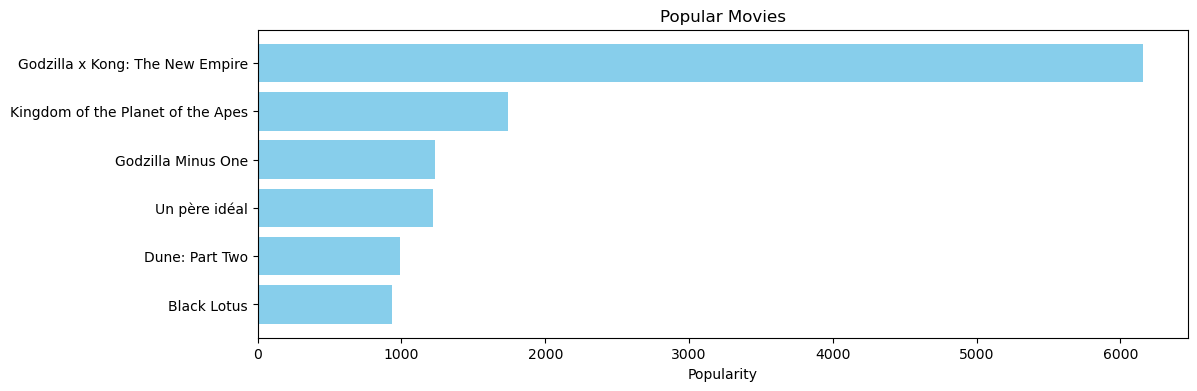

In [11]:
pop = df.sort_values('popularity', ascending= False)
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.barh(pop['title'].head(6),pop['popularity'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")


### content based filtering


In [1]:
df['overview'].head(5)

NameError: name 'df' is not defined

In [15]:
df['overview'] =df['overview'].fillna('')
df['overview'].head(5)

0    Following their explosive showdown, Godzilla a...
1    Several generations in the future following Ca...
2                                                     
3    Postwar Japan is at its lowest point when a ne...
4    Follow the mythic journey of Paul Atreides as ...
Name: overview, dtype: object

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['overview'])
tfidf_matrix.shape

(10000, 24947)

In [17]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [18]:
indices = pd.Series(df.index, index = df['original_title']).drop_duplicates()

In [20]:
def get_recommendations(title, cosine_sim= cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x:x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    mv_indices = [i[0] for i in sim_scores]

    return df['original_title'].iloc[mv_indices]

In [21]:
get_recommendations('Dune: Part Two')

7022                 The Jacket
6127    Paul, Apostle of Christ
27                         Dune
730              Dream Scenario
2726            The Black Demon
4954            The Black Demon
4267            Black Butterfly
368                    Arcadian
9971                      Smoke
5987           Bloodline Killer
Name: original_title, dtype: object

### colaborative filtering


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv("/Users/kaiser/Downloads/archive/ratings.csv")
data.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [5]:
data = data.drop('timestamp',axis=1)

In [6]:
data

,userId,movieId,rating
0,1,110,1.0
1,1,147,4.5
2,1,858,5.0
3,1,1221,5.0
4,1,1246,5.0
...,...,...,...
26024284,270896,58559,5.0
26024285,270896,60069,5.0
26024286,270896,63082,4.5
26024287,270896,64957,4.5


In [7]:
data.shape

(26024289, 3)

In [9]:
train_data=data.iloc[:int(data.shape[0]*0.80)]
test_data=data.iloc[int(data.shape[0]*0.80):]

In [10]:
train_data.shape

(20819431, 3)

In [11]:
test_data.shape

(5204858, 3)

In [2]:
from surprise import SVD
import numpy as np
import surprise
from surprise import Reader, Dataset

In [ ]:
train_sparse_matrix = sparse.csr_matrix((train_data.rating.values, (train_data.userId.values,
                                               train_data.movieId.values)))